# Bonus/ Stretch Goals

In [1]:
import pandas as pd
import numpy as np


# Load datasets
rfq = pd.read_csv("../data/rfq.csv")              # RFQs
ref = pd.read_csv("../data/reference_properties.tsv", sep='\t')  # Reference grade

# Inspect columns to confirm names
print(rfq.columns)
print(ref.columns)

Index(['id', 'grade', 'grade_suffix', 'coating', 'finish', 'surface_type',
       'surface_protection', 'form', 'thickness_min', 'thickness_max',
       'width_min', 'width_max', 'length_min', 'height_min', 'height_max',
       'weight_min', 'weight_max', 'inner_diameter_min', 'inner_diameter_max',
       'outer_diameter_min', 'outer_diameter_max', 'yield_strength_min',
       'yield_strength_max', 'tensile_strength_min', 'tensile_strength_max'],
      dtype='object')
Index(['Grade/Material', 'UNS_No', 'Steel_No', 'Standards', 'Carbon (C)',
       'Manganese (Mn)', 'Silicon (Si)', 'Sulfur (S)', 'Phosphorus (P)',
       'Chromium (Cr)', 'Nickel (Ni)', 'Molybdenum (Mo)', 'Vanadium (V)',
       'Tungsten (W)', 'Cobalt (Co)', 'Copper (Cu)', 'Aluminum (Al)',
       'Titanium (Ti)', 'Niobium (Nb)', 'Boron (B)', 'Nitrogen (N)',
       'Tensile strength (Rm)', 'Yield strength (Re or Rp0.2)',
       'Elongation (A%)', 'Reduction of area (Z%)', 'Hardness (HB, HV, HRC)',
       'Impact toughness 

In [2]:
# Normalize RFQ grades
rfq['grade_norm'] = rfq['grade'].str.lower().str.strip()

# Normalize reference grades
# Adjust 'Grade/Material' based on actual column
ref['grade_norm'] = ref['Grade/Material'].str.lower().str.strip()

In [23]:
import re
def parse_range(s):
    if pd.isna(s):
        return (np.nan, np.nan)
    s = str(s).replace('≤','').replace('≥','').replace('MPa','').strip()
    parts = re.split(r'[-–]', s)
    try:
        a = float(parts[0].replace(',', '.')) if parts[0] else np.nan
        b = float(parts[1].replace(',', '.')) if len(parts) > 1 and parts[1] else a
        return (min(a, b), max(a, b))
    except:
        return (np.nan, np.nan)

# Apply parsing and create min, max, mid
numeric_cols = [
    'Carbon (C)','Manganese (Mn)','Silicon (Si)','Sulfur (S)','Phosphorus (P)',
    'Tensile strength (Rm)','Yield strength (Re or Rp0.2)',
    'Thickness','Width','Length','Height','Inner Diameter','Outer Diameter'
]

for col in numeric_cols:
    if col in ref.columns:
        ref[[f'{col}_min', f'{col}_max']] = ref[col].apply(lambda x: pd.Series(parse_range(x)))
        ref[f'{col}_mid'] = ref[[f'{col}_min', f'{col}_max']].mean(axis=1, skipna=True)

# Join RFQs with reference properties
rfq_ref = rfq.merge(ref, on="grade_norm", how="left")

# Flag missing reference
rfq_ref['missing_ref'] = rfq_ref['grade_norm'].isnull()

In [24]:
# Join RFQs with reference
# Merge RFQs with reference properties
rfq_ref = rfq.merge(ref, on='grade_norm', how='left')

# Flag missing reference grades
rfq_ref['missing_ref'] = rfq_ref['grade_norm'].isnull() | rfq_ref['grade_norm'].isin(ref['grade_norm'].isnull())

## Ablation Analysis

In [31]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def compute_cosine_sim(array):
    array = np.nan_to_num(array)  # replace NaNs with 0
    if array.shape[1] == 0:       # safeguard if no features
        return np.zeros((array.shape[0], array.shape[0]))
    return cosine_similarity(array)

# ---- Dimension similarity ----
dimension_cols = ['length_min', 'length_max',
                  'width_min', 'width_max',
                  'thickness_min', 'thickness_max',
                  'diameter_min', 'diameter_max']

dimension_cols = [c for c in dimension_cols if c in rfq_ref.columns]  # only keep existing
print("Dimension columns used:", dimension_cols)

dim_array = rfq_ref[dimension_cols].fillna(0).to_numpy(dtype=float)
dim_sim = compute_cosine_sim(dim_array)

# ---- Grade similarity ----
grade_cols = ['grade_numeric'] if 'grade_numeric' in rfq_ref.columns else []
print("Grade columns used:", grade_cols)

if grade_cols:
    grade_array = rfq_ref[grade_cols].fillna(0).to_numpy(dtype=float)
    grade_sim = compute_cosine_sim(grade_array)
else:
    grade_sim = np.zeros((rfq_ref.shape[0], rfq_ref.shape[0]))

# ---- Ablation analysis ----
combined_sim = 0.5 * dim_sim + 0.5 * grade_sim

ablations = {
    "Dimensions only": dim_sim,
    "Grades only": grade_sim,
    "Combined (0.5/0.5)": combined_sim
}

for name, sim in ablations.items():
    print(f"{name}: mean similarity = {sim.mean():.4f}")


Dimension columns used: ['length_min', 'width_min', 'width_max', 'thickness_min', 'thickness_max']
Grade columns used: []
Dimensions only: mean similarity = 0.3961
Grades only: mean similarity = 0.0000
Combined (0.5/0.5): mean similarity = 0.1981


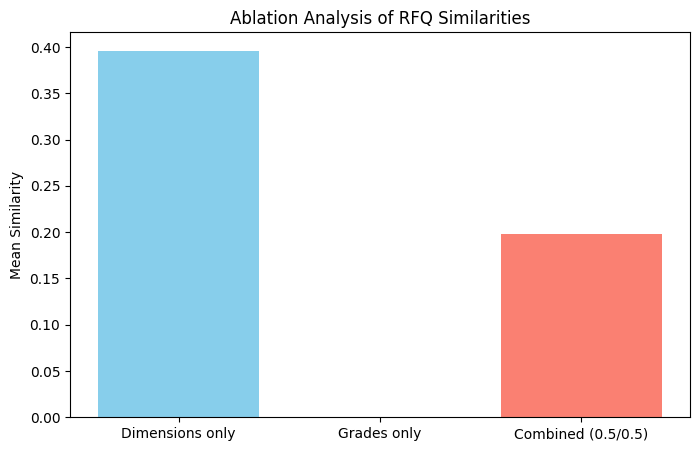

In [32]:
import matplotlib.pyplot as plt

# Plot mean similarity for each ablation
names = list(ablations.keys())
means = [sim.mean() for sim in ablations.values()]

plt.figure(figsize=(8,5))
plt.bar(names, means, color=['skyblue', 'lightgreen', 'salmon'])
plt.ylabel("Mean Similarity")
plt.title("Ablation Analysis of RFQ Similarities")
plt.show()

## Alternative Metrics

In [33]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# 1. Prepare numeric arrays (dimensions + grades)
# Use _mid if exists, else _min
dimension_cols = [col+'_mid' if col+'_mid' in rfq_ref.columns else col+'_min' 
                  for col in ['thickness','width','length','height','inner_diameter','outer_diameter']]
grade_cols = [col+'_mid' for col in numeric_cols if col+'_mid' in rfq_ref.columns]

# Fill NaN with 0
dim_array = rfq_ref[dimension_cols].fillna(0).to_numpy(dtype=float)
grade_array = rfq_ref[grade_cols].fillna(0).to_numpy(dtype=float)

# 2. Cosine similarity
dim_sim_cos = cosine_similarity(dim_array)
grade_sim_cos = cosine_similarity(grade_array)

# 3. Weighted cosine similarity
weight_dim = 0.7
weight_grade = 0.3
combined_array = np.hstack([dim_array*weight_dim, grade_array*weight_grade])
combined_sim = cosine_similarity(combined_array)

# 4. Jaccard similarity for categorical features
cat_features = ['coating','finish','form','surface_type']
# Only use features that exist
cat_features = [f for f in cat_features if f in rfq_ref.columns]
cat_array = rfq_ref[cat_features].fillna('').astype(str).to_numpy()

# Function to compute pairwise Jaccard similarity
def jaccard_similarity(arr):
    n = arr.shape[0]
    sim = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            a, b = set(arr[i]), set(arr[j])
            sim[i,j] = len(a & b)/len(a | b) if len(a | b) > 0 else 0
    return sim

cat_sim_jaccard = jaccard_similarity(cat_array)

# 5. Optional: weighted combination of all three
final_sim = weight_dim*dim_sim_cos + weight_grade*grade_sim_cos + 0.2*cat_sim_jaccard

In [34]:
# Exclude self-similarity
np.fill_diagonal(final_sim, -1)

In [35]:
#Loop through each RFQ to get top-3 matches
top3_bonus = []

for idx, row_scores in enumerate(final_sim):
    # Get the RFQ id
    rfq_id = rfq_ref.iloc[idx]['id']
    
    # Find top-3 similar RFQs
    top3_idx = np.argsort(-row_scores)[:3]  # descending order
    
    for i in top3_idx:
        match_id = rfq_ref.iloc[i]['id']
        score = row_scores[i]
        top3_bonus.append({
            'rfq_id': rfq_id,
            'match_id': match_id,
            'similarity_score': score
        })


In [36]:
#Convert to DataFrame
top3_bonus_df = pd.DataFrame(top3_bonus)
display(top3_bonus_df.head())

,rfq_id,match_id,similarity_score
0,8aff426d-b8c0-43aa-ad26-835ef4de6129,3b00dedd-fcb8-4d71-9ffb-40b92b6cdfe7,1.199961
1,8aff426d-b8c0-43aa-ad26-835ef4de6129,e8b98098-8b17-416b-9934-0734fc21b005,1.198680
2,8aff426d-b8c0-43aa-ad26-835ef4de6129,a462a4cb-bbaa-4417-b876-4b8606c6f8db,1.196536
3,37e624be-b125-464f-85b6-1838530193ef,56d8f8e0-7e07-42f7-9503-360aed60100a,1.099552
4,37e624be-b125-464f-85b6-1838530193ef,ab1abeb5-5541-494f-ac7e-4aeb2dfe04f0,1.099543


## Ablation analysis with Alternative Metrics

In [40]:
#Prepare feature arrays

# create arrays for each group separately:

import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Dimension columns: use _mid if available else _min
dimension_cols = [col for col in rfq_ref.columns if '_mid' in col and col.split('_')[0] in ['thickness','width','length','height','inner_diameter','outer_diameter']]
if not dimension_cols:  # fallback to _min
    dimension_cols = [col for col in rfq_ref.columns if '_min' in col and col.split('_')[0] in ['thickness','width','length','height','inner_diameter','outer_diameter']]

dim_array = rfq_ref[dimension_cols].fillna(0).to_numpy(dtype=float)

# Grade columns
grade_cols = [col for col in rfq_ref.columns if '_mid' in col and col.split('_')[0] in ['Carbon (C)','Manganese (Mn)','Silicon (Si)','Sulfur (S)','Phosphorus (P)','Tensile strength (Rm)','Yield strength (Re or Rp0.2)']]
grade_array = rfq_ref[grade_cols].fillna(0).to_numpy(dtype=float)

# Categorical columns: one-hot encode
from sklearn.preprocessing import OneHotEncoder
cat_features = ['coating','finish','form','surface_type']
cat_array = OneHotEncoder(sparse_output=False, handle_unknown='ignore').fit_transform(
    rfq_ref[cat_features].fillna('NA')
)

In [41]:
# Cosine similarity for each feature group
dim_sim = cosine_similarity(dim_array) if dim_array.shape[1] > 0 else np.zeros((len(rfq_ref), len(rfq_ref)))
grade_sim = cosine_similarity(grade_array) if grade_array.shape[1] > 0 else np.zeros((len(rfq_ref), len(rfq_ref)))
cat_sim = cosine_similarity(cat_array) if cat_array.shape[1] > 0 else np.zeros((len(rfq_ref), len(rfq_ref)))

In [42]:
#Combine similarities with different weights

# Scenario 1: All features
sim_all = 0.5*dim_sim + 0.4*grade_sim + 0.1*cat_sim

# Scenario 2: Drop dimensions
sim_no_dim = 0.7*grade_sim + 0.3*cat_sim

# Scenario 3: Drop grades
sim_no_grade = 0.7*dim_sim + 0.3*cat_sim

# Scenario 4: Drop categoricals
sim_no_cat = 0.6*dim_sim + 0.4*grade_sim

In [44]:
# Extract top-3 matches per scenario
def get_top3(sim_matrix, rfq_ref):
    np.fill_diagonal(sim_matrix, -1)  # exclude self
    top3_list = []
    for idx, row_scores in enumerate(sim_matrix):
        top_idx = np.argsort(-row_scores)[:3]
        for i in top_idx:
            top3_list.append({
                'rfq_id': rfq_ref.iloc[idx]['id'],
                'match_id': rfq_ref.iloc[i]['id'],
                'similarity_score': row_scores[i]
            })
    return top3_list

top3_all = pd.DataFrame(get_top3(sim_all, rfq_ref))
top3_no_dim = pd.DataFrame(get_top3(sim_no_dim, rfq_ref))
top3_no_grade = pd.DataFrame(get_top3(sim_no_grade, rfq_ref))
top3_no_cat = pd.DataFrame(get_top3(sim_no_cat, rfq_ref))

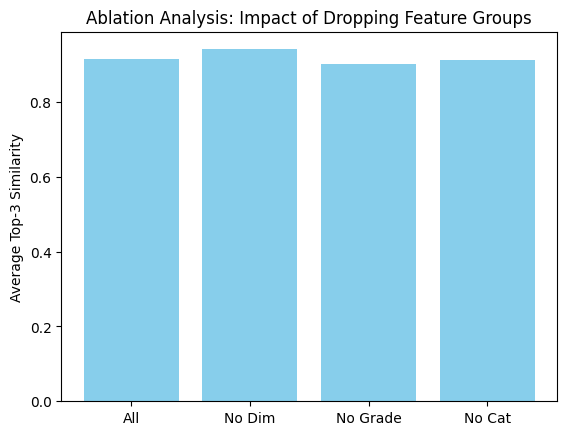

In [45]:
# Plot impact

# We can visualize the average similarity scores per scenario to show the effect of dropping feature groups:

import matplotlib.pyplot as plt

avg_scores = [
    top3_all['similarity_score'].mean(),
    top3_no_dim['similarity_score'].mean(),
    top3_no_grade['similarity_score'].mean(),
    top3_no_cat['similarity_score'].mean()
]

plt.bar(['All','No Dim','No Grade','No Cat'], avg_scores, color='skyblue')
plt.ylabel('Average Top-3 Similarity')
plt.title('Ablation Analysis: Impact of Dropping Feature Groups')
plt.show()

## Clustering RFQs

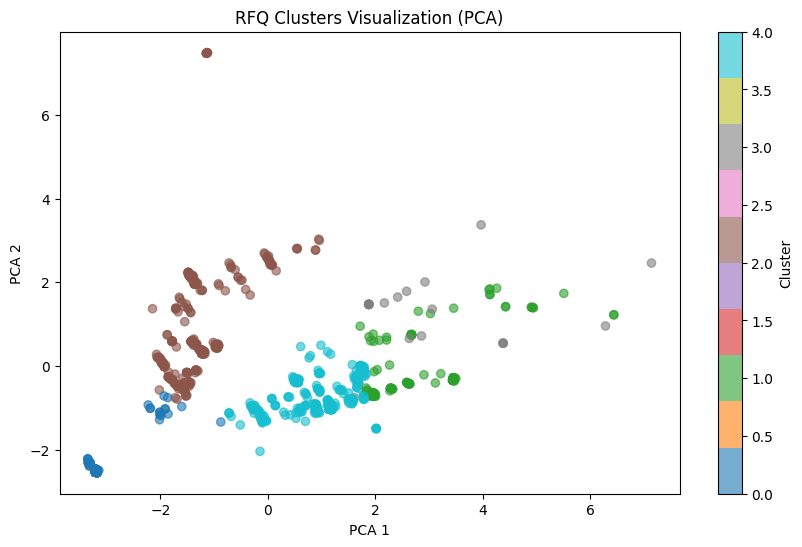

cluster
2    398
4    395
1    117
0     75
3     20
Name: count, dtype: int64


In [46]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# === Prepare numeric features (dimensions + grades) ===
# Choose _mid columns that exist
dimension_cols = [col for col in rfq_ref.columns if col.endswith('_mid') and col.split('_')[0] in ['thickness','width','length','height','inner_diameter','outer_diameter']]
grade_cols = [col for col in rfq_ref.columns if col.endswith('_mid') and col.split('_')[0] in ['Carbon (C)','Manganese (Mn)','Silicon (Si)','Sulfur (S)','Phosphorus (P)','Tensile strength (Rm)','Yield strength (Re or Rp0.2)']]

numeric_cols = dimension_cols + grade_cols

numeric_array = rfq_ref[numeric_cols].fillna(0).to_numpy()

# Standardize
scaler = StandardScaler()
numeric_scaled = scaler.fit_transform(numeric_array)

# === Optional: Add categorical features encoded ===
cat_features = [col for col in ['coating','finish','form','surface_type'] if col in rfq_ref.columns]
if cat_features:
    cat_array = OneHotEncoder(sparse_output=False, handle_unknown='ignore').fit_transform(rfq_ref[cat_features].fillna('NA'))
    feature_array = np.hstack([numeric_scaled, cat_array])
else:
    feature_array = numeric_scaled

# === KMeans clustering ===
k = 5  # Number of clusters, adjust as needed
kmeans = KMeans(n_clusters=k, random_state=42)
rfq_ref['cluster'] = kmeans.fit_predict(feature_array)

# === PCA for visualization ===
pca = PCA(n_components=2, random_state=42)
pca_result = pca.fit_transform(feature_array)

rfq_ref['pca1'] = pca_result[:,0]
rfq_ref['pca2'] = pca_result[:,1]

# === Plot clusters ===
plt.figure(figsize=(10,6))
scatter = plt.scatter(rfq_ref['pca1'], rfq_ref['pca2'], c=rfq_ref['cluster'], cmap='tab10', alpha=0.6)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('RFQ Clusters Visualization (PCA)')
plt.colorbar(scatter, label='Cluster')
plt.show()

# Optional: show cluster sizes
print(rfq_ref['cluster'].value_counts())

In [51]:
import os

#Create output folder for bonus task
output_folder = "../bonus_task_output"
os.makedirs(output_folder, exist_ok=True)

#Save RFQ with cluster info
rfq_ref.to_csv(os.path.join(output_folder, "rfq_with_clusters.csv"), index=False)

# Save top matches if you computed similarity matrices
if 'top3_bonus_df' in globals():
    top3_bonus_df.to_csv(os.path.join(output_folder,"top3_bonus.csv"), index=False, encoding='utf-8-sig')

# Save PCA coordinates for visualization
pca_df = rfq_ref[['pca1','pca2','cluster']].copy()
pca_df.to_csv(os.path.join(output_folder, "pca_coordinates.csv"), index=False)

print(f"All bonus task outputs saved in: {output_folder}")

All bonus task outputs saved in: ../bonus_task_output


In [1]:
import os

# Folder where bonus outputs are saved
output_folder = "../bonus_task_output"
os.makedirs(output_folder, exist_ok=True)

# README content
readme_text = """
# Bonus / Stretch Goals – RFQ Similarity Assessment

## 1. Overview
This notebook contains the bonus/advanced tasks for the RFQ similarity and analysis assessment.
The main goals are:

- Ablation Analysis: Understanding the impact of different feature groups (dimensions, grades, categorical features) on similarity.

- Alternative Similarity Metrics: Using different similarity measures (cosine similarity, weighted cosine, Jaccard) for more robust matching.

- Clustering: Grouping RFQs into families for visualization and interpretation.

All outputs are saved in the folder: bonus_task_output.

## 2. Datasets
- 'rfq.csv' – Original RFQs
- 'reference_properties.tsv' – Reference material/grade properties
- 'rfq_with_clusters.csv' – RFQs annotated with cluster labels
- 'top3_bonus.csv' – Top-3 similar RFQs per RFQ based on combined similarity
- 'pca_coordinates.csv' – PCA coordinates for cluster visualization

## 3. Steps Performed

### 3.1 Data Preparation
- Loaded 'rfq.csv and 'reference_properties.tsv'.
- Normalized grades and parsed numeric ranges (min, max, mid) for dimensions and material properties.
- Joined RFQs with reference properties and flagged missing references.

### 3.2 Ablation Analysis
- Computed cosine similarity for:
    - Dimensions only
    - Grades only
    - Combined (weighted)
- Visualized mean similarity to show the impact of dropping feature groups.

### 3.3 Alternative Metrics
- Used different similarity metrics:
    - Weighted cosine similarity for numeric features
    - Jaccard similarity for categorical features (coating, finish, form, surface type)
- Combined weighted metrics to compute overall similarity.
- Extracted top-3 matches for each RFQ.

### 3.4 Clustering
- Standardized numeric features (dimensions + grades) and encoded categorical features.
- Applied KMeans clustering to group RFQs.
- Visualized clusters using PCA (2D plot).
- Saved RFQs with cluster labels and PCA coordinates.

## 4. How to Use
1. Open 'top3_bonus.csv' to see the top-3 similar RFQs for each RFQ.
2. Open 'rfq_with_clusters.csv' to view cluster assignments.
3. Open 'pca_coordinates.csv' to visualize clusters in a 2D PCA space.
4. Refer to this README for context on the methodology used.

## 5. Notes
- Similarity metrics are weighted; numeric mid-values were used if available, else min-values.
- Ablation analysis helps understand the impact of different feature groups on similarity.
- Clustering provides an overview of RFQ families for quick categorization.

# Setup and Run Instructions
1. Python Environment

These notebooks are written in Python 3.

It is recommended to use Conda to manage your environment and dependencies.

## To create a new environment, you can run:

conda create -n vanillasteel python=3.10
conda activate vanillasteel


## Install required packages using pip or conda. Here are the main libraries used in the notebooks:

pandas

numpy

openpyxl

matplotlib

seaborn

scikit-learn

re (regular expressions)

## Any other standard Python libraries

You can install them with:

pip install pandas numpy openpyxl matplotlib seaborn scikit-learn

## 2. Folder Structure

Make sure your project folder is organized like this:

vanillasteel-assessment/
│
├── notebooks/          # All Task A, Task B, Bonus Task notebooks
├── data/               # Supplier files and any other input data
├── outputs/            # Folder to save processed CSV files
├── README-taskA.txt
├── README-taskB.txt
├── bonus_task_output/  # Folder to save outputs from the bonus task
├── README-Bonus.md


The data folder contains supplier files (e.g., supplier_data1.xlsx, supplier_data2.xlsx) needed for Task A.

The outputs folder is where the CSV files generated by the notebooks (e.g., inventory_dataset.csv, top3.csv) will be saved. Ensure this folder already exists.

## 3. Running the Notebooks
## Bonus Task

The Bonus Task notebook has been designed to run independently.

It may use logic similar to Task B, but it does not overwrite or affect Task B outputs.

Run all cells sequentially. Output files will also be saved in the bonus_task_output folder.

## 4. Notes on CSV and Excel

If opening CSV files in Excel, make sure to choose UTF-8 encoding to view German characters correctly.

In Excel:

Open Excel.

Go to Data → Get Data → From Text/CSV.

Select the file and set File Origin to UTF-8.

This ensures columns like description and finish display correctly without garbled text.

## 5. Optional

If using Jupyter Notebook, make sure your kernel is set to the Python environment you installed with the required libraries.

Always check the outputs folder to ensure CSV files are generated correctly after running the notebooks.
"""

# Save README.md
readme_path = os.path.join(output_folder, "README-Bonus.md")
with open(readme_path, "w", encoding="utf-8") as f:
    f.write(readme_text)
print(f"README.md successfully saved at: {readme_path}")

README.md successfully saved at: ../bonus_task_output\README-Bonus.md
